In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm, lognorm

import pickle

In [2]:
fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision = pickle.load(file)

# close file
file.close()

fname = 'results_raw_50.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_50 = pickle.load(file)

# close file
file.close()

fname = 'results_raw_25.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_25 = pickle.load(file)

# close file
file.close()

In [5]:
df_25 = pd.concat(results_decision_25, names=['subject'])
df_50 = pd.concat(results_decision_50, names=['subject'])

In [8]:
mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export

,mu,sigma,exp(mu)
theta,-1.326171,0.194849,0.265492
Lambda,0.416135,0.714927,1.516091
tau,-1.377509,0.179758,0.252206
alpha,-0.245509,0.082848,0.782306
gamma,-0.138041,0.678683,0.871063
error,NaN,1.922277,NaN


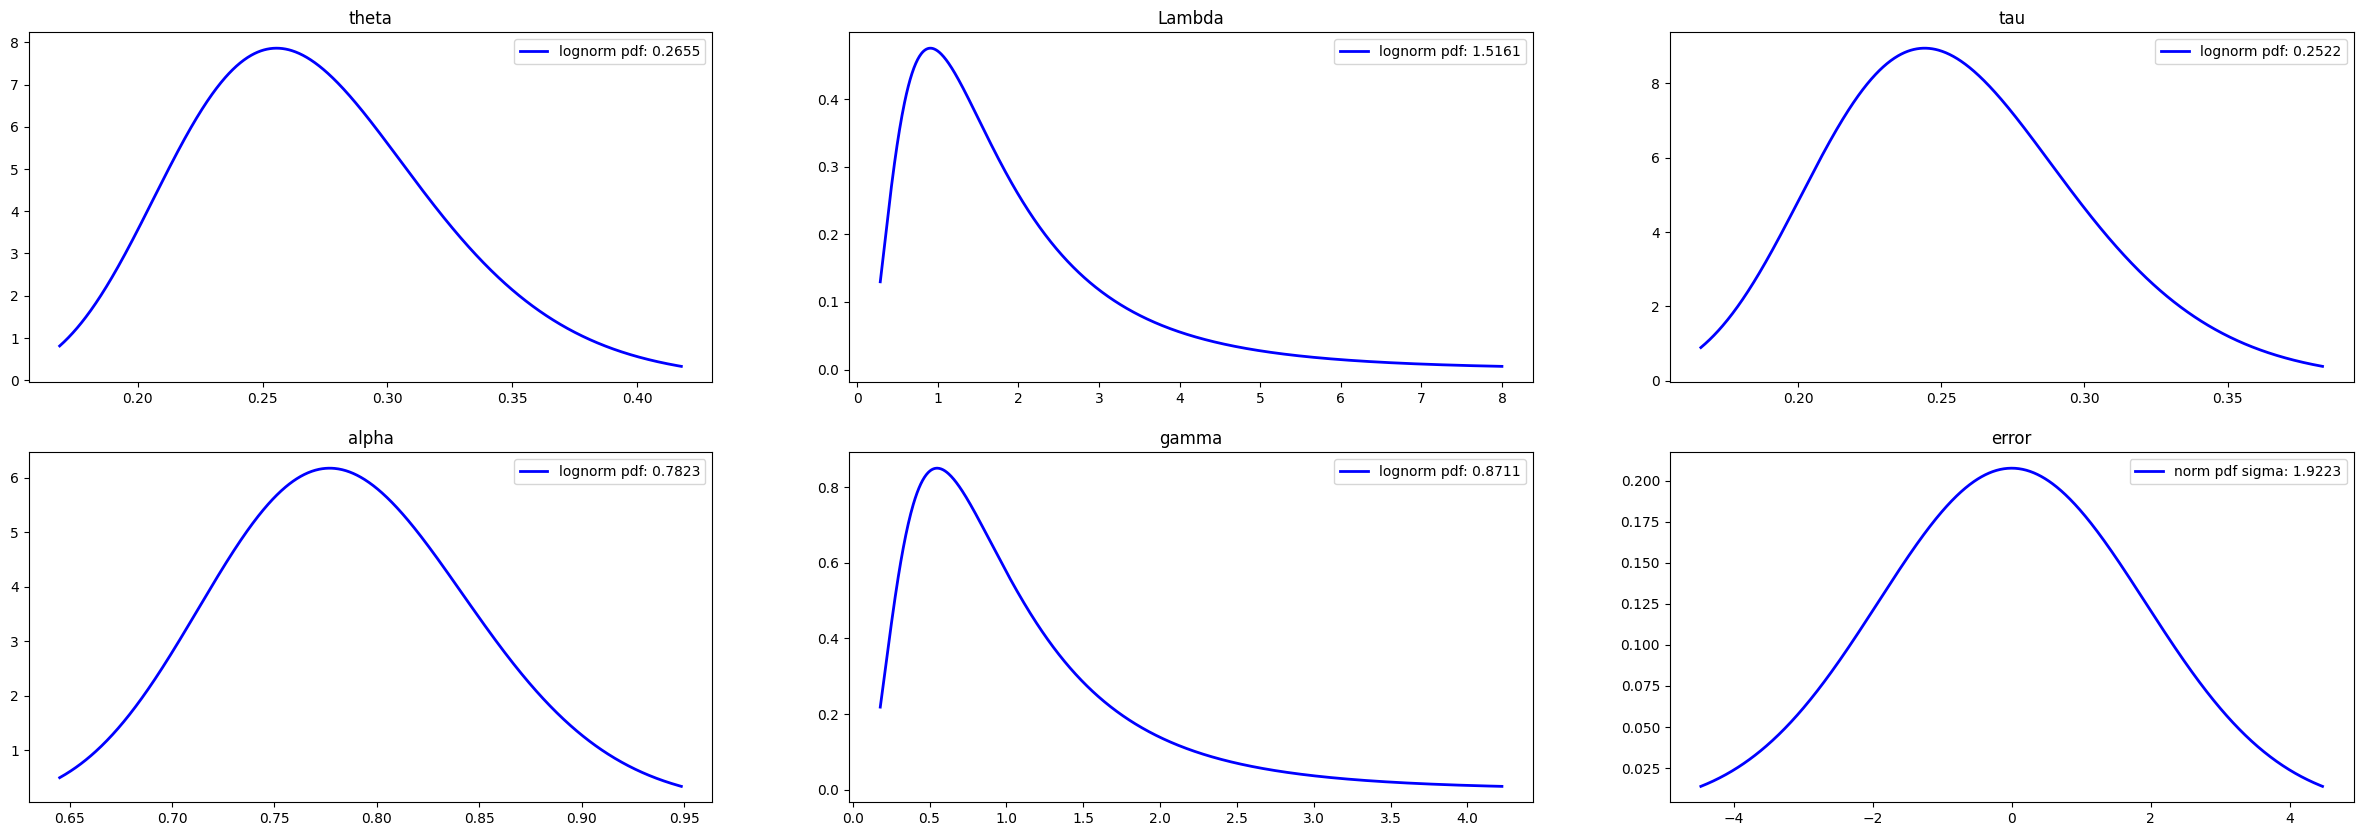

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(30,10))
for param,axis in zip(['theta', 'Lambda', 'tau', 'alpha', 'gamma','error'], [(0, 0), (0, 1), (0 ,2), (1, 0), (1, 1), (1, 2)]):
    if param=='error':
        scale = distro_estimates['sigma'][param]
        frozen_norm = norm(0, scale)
        x = np.linspace(norm.ppf(.01, 0, scale),norm.ppf(.99, 0, scale), 1000)
        axes[axis].plot(x, frozen_norm.pdf(x), 'b-', lw=2, alpha=1, label=f'norm pdf sigma: {scale:.4f}')
    else:
        s = distro_estimates['sigma'][param]
        scale = np.exp(distro_estimates['mu'][param])
        frozen_lognorm = lognorm(s, 0, scale)
        x = np.linspace(lognorm.ppf(.01, s, 0, scale),lognorm.ppf(.99, s, 0, scale), 1000)
        axes[axis].plot(x, frozen_lognorm.pdf(x), 'b-', lw=2, alpha=1, label=f'lognorm pdf: {scale:.4f}')
    axes[axis].legend()
    axes[axis].set_title(param)

plt.show()

In [13]:
results_decision_50.keys()
df = results_decision_50['11112']

In [14]:
import pymc as pm
import numpy as np
import pandas as pd
import aesara.tensor as at

# Load the investment decisions data
# data = pd.read_csv('../data/investment_decisions.csv')

# Assume df is your subject's DataFrame, and distro_estimates is as defined

FACTOR = 1/100
beta = 0.88

# Helper functions rewritten for Aesara tensors

def lognormal_pdf(value, mu, sigma):
    ''' Function to calculate the lognormal density'''
    shape  = sigma
    loc    = 0
    scale  = np.exp(mu)
    return lognorm.pdf(value, shape, loc, scale)

def normal_pdf(value, mu, sigma):
    ''' Function to calculate the lognormal density'''
    loc    = 0
    scale  = sigma
    return norm.pdf(value, loc, scale)

def calc_eta(green, red, theta, prob_ambi):
    # prob_ambi is always provided in your data
    return green + prob_ambi * theta

def calc_subj_prob(prob, gamma):
    return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

def calc_subj_values(x, Lambda, alpha, beta):
    return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)

def calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma, prob_ambi):
    prob_g = at.clip(calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
    prob_l = at.clip(calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
    u = (
        calc_subj_values(gain, Lambda, alpha, beta) * calc_subj_prob(prob_g, gamma) +
        calc_subj_values(loss, Lambda, alpha, beta) * calc_subj_prob(prob_l, gamma)
    )
    return u

def calc_prob_invest(utility, tau, error):
    return 1 / (1 + at.exp(-tau * (utility - error)))



In [ ]:
# Prepare data

gain      = df['gain'].values * FACTOR
loss      = df['loss'].values * FACTOR
prob_win  = df['prob_win'].values
prob_loss = df['prob_loss'].values
prob_ambi = df['prob_ambi'].values
invest    = df['invest'].values.astype(int)

In [ ]:




with pm.Model() as model:
    # Priors
    theta   = pm.Lognormal('theta', mu=distro_estimates['mu']['theta'], sigma=distro_estimates['sigma']['theta'])
    Lambda  = pm.Lognormal('Lambda', mu=distro_estimates['mu']['Lambda'], sigma=distro_estimates['sigma']['Lambda'])
    tau     = pm.Lognormal('tau', mu=distro_estimates['mu']['tau'], sigma=distro_estimates['sigma']['tau'])
    alpha   = pm.Lognormal('alpha', mu=distro_estimates['mu']['alpha'], sigma=distro_estimates['sigma']['alpha'])
    gamma   = pm.Lognormal('gamma', mu=distro_estimates['mu']['gamma'], sigma=distro_estimates['sigma']['gamma'])
    error   = pm.Normal('error', mu=0, sigma=distro_estimates['sigma']['error'])

    # Utility and probability
    utility = calc_pt_utility(
        gain=gain,
        loss=loss,
        prob_win=prob_win,
        prob_loss=prob_loss,
        theta=theta,
        Lambda=Lambda,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        prob_ambi=prob_ambi
    )
    p = calc_prob_invest(utility, tau, error)

    # Likelihood
    invest_obs = pm.Bernoulli('invest_obs', p=p, observed=invest)

    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.9)

# You can now analyze the trace object for posterior inference

/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_45645/2169198279.py:37: RuntimeWarning: invalid value encountered in power
  return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, Lambda, tau, alpha, gamma, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


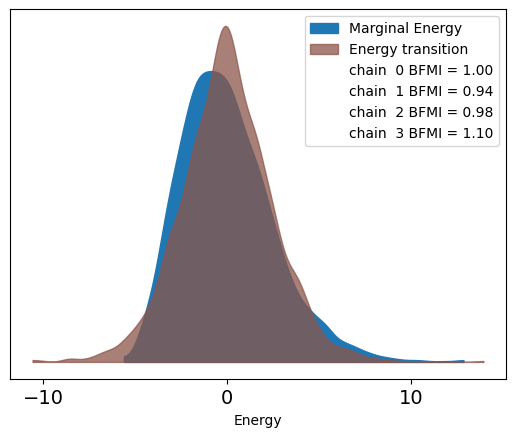

X axis values (energy):
[23.62433337 23.7431494  32.01204251 ... 23.49145382 24.27943781
 26.64848417]


In [ ]:
import arviz as az

az.plot_energy(trace)
plt.xlabel("Energy")
energy = trace.sample_stats["energy"].values.flatten()
plt.xticks(np.round(np.linspace(-10, 10, num=3), 2))
plt.show()
print("X axis values (energy):")
print(energy)

array([[<Axes: title={'center': 'error'}>,
        <Axes: title={'center': 'error'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'Lambda'}>,
        <Axes: title={'center': 'Lambda'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>]], dtype=object)

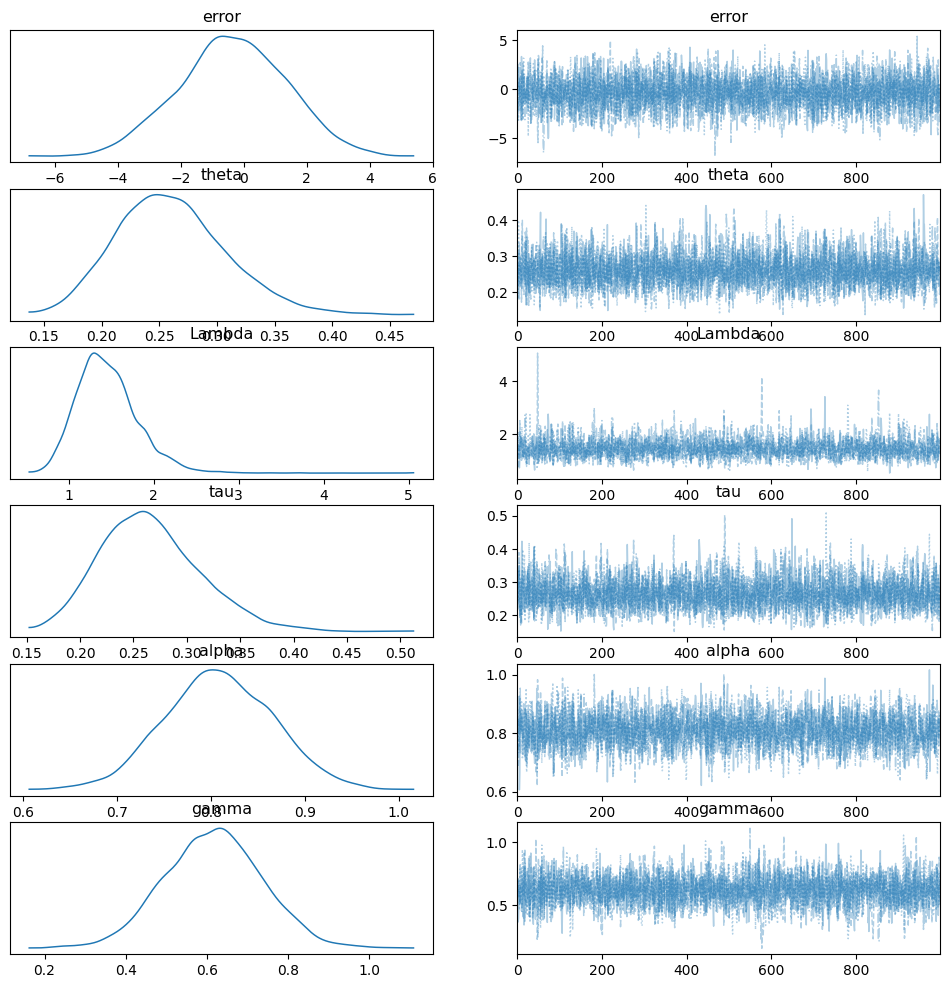

In [21]:
az.plot_trace(trace, combined=True)


In [27]:
# Extract posterior means for each parameter from the trace
summary = az.summary(trace, var_names=["theta", "Lambda", "tau", "alpha", "gamma", "error"])
print(summary[['mean', 'hdi_3%', 'hdi_97%']])

         mean  hdi_3%  hdi_97%
theta   0.260   0.172    0.348
Lambda  1.454   0.845    2.134
tau     0.266   0.188    0.362
alpha   0.808   0.703    0.917
gamma   0.615   0.390    0.837
error  -0.351  -3.581    2.752
